In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

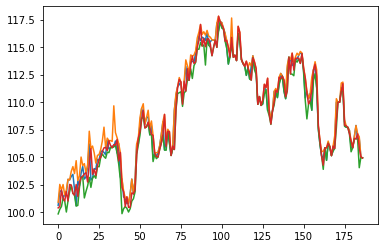

In [43]:
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"

training = pd.read_csv(f"{TICKER_DIR}\\MA_AIZP.csv", header=0)
training = training.iloc[:, :4].values
plt.plot(training, label="Ticker Values")

In [44]:
def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(x[:train_size]))
trainY = Variable(torch.Tensor(y[:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

torch.Size([145, 4, 4])
torch.Size([145, 4])
torch.Size([37, 4, 4])
torch.Size([37, 4])


In [50]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [64]:
num_epochs = 2000
learning_rate = 0.01

input_size = 4
hidden_size = 4
num_layers = 1

num_classes = 4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, loss: {loss.item()}")

Epoch: 0, loss: 0.44571518898010254
Epoch: 100, loss: 0.006028631702065468
Epoch: 200, loss: 0.0049009486101567745
Epoch: 300, loss: 0.0042244200594723225
Epoch: 400, loss: 0.003803812200203538
Epoch: 500, loss: 0.0036149127408862114
Epoch: 600, loss: 0.0035301619209349155
Epoch: 700, loss: 0.003486332716420293
Epoch: 800, loss: 0.003459002124145627
Epoch: 900, loss: 0.0034392187371850014
Epoch: 1000, loss: 0.0034235615748912096
Epoch: 1100, loss: 0.003410459030419588
Epoch: 1200, loss: 0.0033990314695984125
Epoch: 1300, loss: 0.0033887086901813745
Epoch: 1400, loss: 0.003379102097824216
Epoch: 1500, loss: 0.0033699367195367813
Epoch: 1600, loss: 0.0033610190730541945
Epoch: 1700, loss: 0.003352210158482194
Epoch: 1800, loss: 0.0033434126526117325
Epoch: 1900, loss: 0.003334550652652979


torch.Size([182, 4, 4])
torch.Size([182, 4])


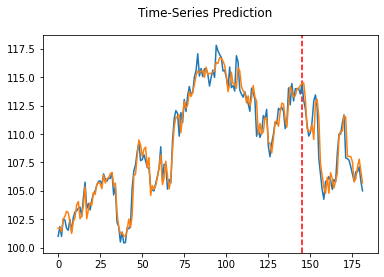

In [74]:
lstm.eval()
train_predict = lstm(dataX)
print(dataX.shape)
print(train_predict.shape)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

open_ = data_predict[:, -1]
y_  = dataY_plot[:, -1]

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(y_)
plt.plot(open_)
plt.suptitle('Time-Series Prediction')
plt.show()

In [75]:
def forecast(model, batch_size, row):
    X = row[0:-1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

yhat = forecast(lstm, 1, open_)

AttributeError: 'LSTM' object has no attribute 'predict'

torch.Size([145, 4, 4])
torch.Size([145, 4])
torch.Size([37, 4, 4])
torch.Size([37, 4])


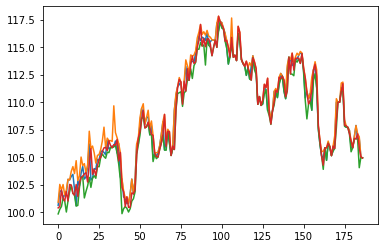

In [79]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"

training = pd.read_csv(f"{TICKER_DIR}\\MA_AIZP.csv", header=0)
training = training.iloc[:, :4].values
plt.plot(training, label="Ticker Values")

def sliding_windows(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(y))

trainX = Variable(torch.Tensor(x[:train_size]))
trainY = Variable(torch.Tensor(y[:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

In [93]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(4, 4, 4), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(4, 4, 4), stateful=True))
model.add(Dense(4))
model.compile(loss="mean_squared_error", optimizer="adam")

In [95]:
for i in range(100):
    model.fit(trainX[1:], trainY[1:], epochs=1, batch_size=4, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 0s - loss: 0.3364
Epoch 1/1
 - 0s - loss: 0.2068
Epoch 1/1
 - 0s - loss: 0.1356
Epoch 1/1
 - 0s - loss: 0.0991
Epoch 1/1
 - 0s - loss: 0.0765
Epoch 1/1
 - 0s - loss: 0.0613
Epoch 1/1
 - 0s - loss: 0.0501
Epoch 1/1
 - 0s - loss: 0.0417
Epoch 1/1
 - 0s - loss: 0.0355
Epoch 1/1
 - 0s - loss: 0.0309
Epoch 1/1
 - 0s - loss: 0.0276
Epoch 1/1
 - 0s - loss: 0.0250
Epoch 1/1
 - 0s - loss: 0.0230
Epoch 1/1
 - 0s - loss: 0.0214
Epoch 1/1
 - 0s - loss: 0.0201
Epoch 1/1
 - 0s - loss: 0.0190
Epoch 1/1
 - 0s - loss: 0.0181
Epoch 1/1
 - 0s - loss: 0.0173
Epoch 1/1
 - 0s - loss: 0.0165
Epoch 1/1
 - 0s - loss: 0.0159
Epoch 1/1
 - 0s - loss: 0.0152
Epoch 1/1
 - 0s - loss: 0.0146
Epoch 1/1
 - 0s - loss: 0.0141
Epoch 1/1
 - 0s - loss: 0.0136
Epoch 1/1
 - 0s - loss: 0.0131
Epoch 1/1
 - 0s - loss: 0.0126
Epoch 1/1
 - 0s - loss: 0.0122
Epoch 1/1
 - 0s - loss: 0.0118
Epoch 1/1
 - 0s - loss: 0.0114
Epoch 1/1
 - 0s - loss: 0.0111
Epoch 1/1
 - 0s - loss: 0.0108
Epoch 1/1
 - 0s - loss: 0.0105
Epoch 1/

In [111]:
train_predict = model.predict(trainX[1:], batch_size=4)
model.reset_states()
test_predict = model.predict(testX[1:], batch_size=4)

train_predict = sc.inverse_transform(train_predict)
trainY = sc.inverse_transform(trainY)
test_predict = sc.inverse_transform(test_predict)
testY = sc.inverse_transform(testY)

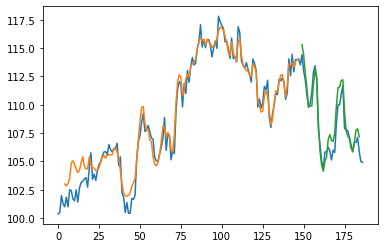

In [129]:
trainPredictPlot = np.empty_like(training_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[4:len(train_predict)+4, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(training_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(4)+1:len(training_data)-2, :] = test_predict
# plot baseline and predictions
plt.plot(sc.inverse_transform(training_data)[:, 3])
plt.plot(trainPredictPlot[:, 3])
plt.plot(testPredictPlot[:, 3])
plt.show()